In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from evoman.environment import Environment
from controller_custom import player_controller
# from evoman.controller import Controller
from multiprocessing import Pool
from scipy.stats import ttest_ind, mannwhitneyu
import pandas as pd
import warnings

pygame 2.6.0 (SDL 2.28.4, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
results_EA1_EG1 = pd.read_csv('results\\results_EA1_EG1.csv')
results_EA2_EG1 = pd.read_csv('results\\results_EA2_EG1.csv')

# Do the same here for group 2

# Group 1

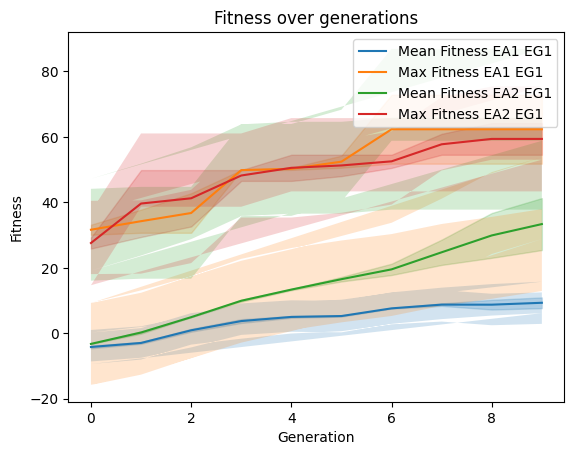

In [3]:
# Make a lineplot of the fitness over generations 
plt.figure()
sns.lineplot(x='Generation', y='Mean Fitness', data=results_EA1_EG1, label='Mean Fitness EA1 EG1')
sns.lineplot(x='Generation', y='Max Fitness', data=results_EA1_EG1, label='Max Fitness EA1 EG1')
sns.lineplot(x='Generation', y='Mean Fitness', data=results_EA2_EG1, label='Mean Fitness EA2 EG1')
sns.lineplot(x='Generation', y='Max Fitness', data=results_EA2_EG1, label='Max Fitness EA2 EG1')

# Calculate the standard deviation mean fitness over the generations
std_EA1_EG1 = results_EA1_EG1['Mean Fitness'].std()
std_EA2_EG1 = results_EA2_EG1['Mean Fitness'].std()

# Calculate the standard deviation max fitness over the generations
std_EA1_EG1_max = results_EA1_EG1['Max Fitness'].std()
std_EA2_EG1_max = results_EA2_EG1['Max Fitness'].std()

# Include the standard deviation in the plot
plt.fill_between(results_EA1_EG1['Generation'], results_EA1_EG1['Mean Fitness']-std_EA1_EG1, results_EA1_EG1['Mean Fitness']+std_EA1_EG1, alpha=0.2)
plt.fill_between(results_EA2_EG1['Generation'], results_EA2_EG1['Mean Fitness']-std_EA2_EG1, results_EA2_EG1['Mean Fitness']+std_EA2_EG1, alpha=0.2)

plt.fill_between(results_EA1_EG1['Generation'], results_EA1_EG1['Max Fitness']-std_EA1_EG1_max, results_EA1_EG1['Max Fitness']+std_EA1_EG1_max, alpha=0.2)
plt.fill_between(results_EA2_EG1['Generation'], results_EA2_EG1['Max Fitness']-std_EA2_EG1_max, results_EA2_EG1['Max Fitness']+std_EA2_EG1_max, alpha=0.2)

plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness over generations')
plt.legend()
plt.show()


# Group 2

# Gain


In [17]:
def calculate_gain(solution, enemies, experiment_name, n_hidden_neurons, num_tests=5):
    # Create the directory if it does not exist
    os.makedirs(experiment_name, exist_ok=True)
    solution = np.array(solution)
    
    env = Environment(
        experiment_name=experiment_name,
        enemies=enemies,
        playermode="ai",
        player_controller=player_controller(n_hidden_neurons),
        enemymode="static",
        level=2,
        speed="fastest",
        visuals=False,
        randomini="yes",
        multiplemode="yes",
    )
    
    gains = []
    for _ in range(num_tests):
        num_sensors = env.get_num_sensors()
                
        env.player_controller.set(solution, num_sensors)
        f, p_e, e_e, _ = env.play(pcont=solution)
        gain = p_e - e_e
        print(f'Gain: {gain:.4f}')
        gains.append(gain)
    
    return gains


In [18]:
best_solution_EA1_EG1 = np.loadtxt('results\\best_solution_A_enemy_group_1.txt')
best_solution_EA2_EG1 = np.loadtxt('results\\best_solution_B_enemy_group_1.txt')


In [23]:
# Calculate the gain for the best solution of EA1 EG1 on all enemies
enemies = np.array(range(1, 9))

gains = calculate_gain(best_solution_EA1_EG1, enemies, 'gain_EA1_EG1', 10, 10)



MESSAGE: Pygame initialized for simulation.
Gain: -26.5300
Gain: -22.1409
Gain: -20.1728
Gain: -22.3059
Gain: -25.4736
Gain: -26.7321
Gain: -21.7798
Gain: -20.7134
Gain: -24.3673
Gain: -18.6722


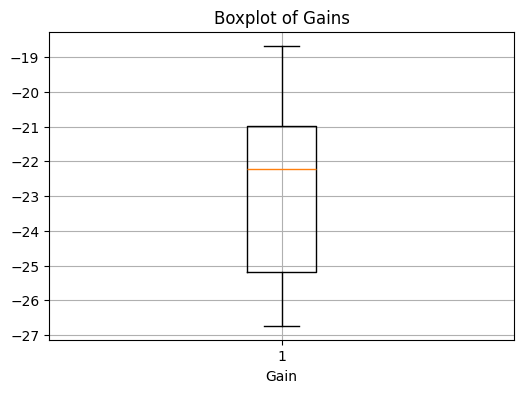

: 

In [24]:
plt.figure(figsize=(6, 4))
plt.boxplot(gains)
plt.title("Boxplot of Gains")
plt.xlabel("Gain")
plt.grid(True)

# Show the plot
plt.show()
